### Imports

In [1]:
!pip install --upgrade shap
import shap
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.7 MB/s eta 0:00:00


### Data Organization for Tree Model
Using engineered data from the proposal & model file in R

Random Sample of 5% from the data (not enough computational power to process the whole thing)
Sample was randomly selected while keeping the ratio's in the NOPRIOR column.

In [18]:
# Data Import
data = pd.read_csv('/content/data_sample.csv')

# Drop features we find irrelevant
# columns_to_drop = ['AGE','PSOURCE','DSMCRIT']
# data = data.drop(columns=columns_to_drop)

# Separate the features (X) and the target variable (y)
X = data.drop('NOPRIOR', axis=1)
y = data['NOPRIOR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
def create_decision_matrix(predictions, targets):
    # Round the predictions to the nearest integer
    rounded_predictions = np.round(predictions)
    
    # Create the confusion matrix
    conf_matrix = confusion_matrix(targets, rounded_predictions)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(targets, rounded_predictions)
    
    # Create a dataframe for the confusion matrix
    decision_matrix = pd.DataFrame(conf_matrix, index=np.unique(targets), columns=np.unique(targets))
    
    # Print the decision matrix
    print("Decision Matrix:")
    print(decision_matrix)
    
    # Print the accuracy score
    print("Accuracy:", accuracy)
    return ("")


### Regression Tree Model Assembly
Creating an overfitted model to later use it as an explainer of the dominant features in every group

In [21]:
# Create and fit the model
model_Num_reg_tree = DecisionTreeRegressor(max_depth=40, 
                                               min_samples_leaf=1, 
                                               min_samples_split=2)
model_Num_reg_tree = model_Num_reg_tree.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = model_Num_reg_tree.predict(X_train)
y_test_pred = model_Num_reg_tree.predict(X_test)

# Replace values greater than 5 with 5
y_train_pred[y_train_pred > 5] = 5
# Replace negative values with 0
y_train_pred[y_train_pred < 0] = 0
y_train_pred = np.round(y_train_pred)

# Replace values greater than 5 with 5
y_test_pred[y_test_pred > 5] = 5
# Replace negative values with 0
y_test_pred[y_test_pred < 0] = 0
y_test_pred = np.round(y_test_pred)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

Training R-squared: 0.9506772573898727
Testing R-squared: -0.3800431249286429


In [22]:
print("Matrix on Test")
print(create_decision_matrix(y_test_pred, y_test))
print('''

''')
print("Matrix on Train")
print(create_decision_matrix(y_train_pred, y_train))


Matrix on Test
Decision Matrix:
     0    1    2    3   4    5
0  952  432  224  136  88  191
1  422  335  145   92  77  164
2  187  149  122   61  36  158
3  114   87   63   75  30  107
4   65   53   34   29  38   64
5  183  161  125  130  83  381
Accuracy: 0.32849991368893494




Matrix on Train
Decision Matrix:
      0     1     2     3     4     5
0  7796   196   167    25     3     0
1   183  4417   120    57    11     0
2     2   114  2726    35    50     0
3     0    18   110  1676    40     1
4     0     7    38    29  1007     3
5     0     4    91   102   158  3984
Accuracy: 0.9324989210185585



### Shap Analysis for Tree Model

In [23]:
# working 100% of the data set
part = int(len(X_train))
train_sample = X_train.sample(n=part)

# Compute SHAP values
explainer = shap.Explainer(model_Num_reg_tree, train_sample, feature_names=train_sample.columns, n_jobs=-1)
shap_values = explainer.shap_values(train_sample)

 98%|===================| 22753/23170 [00:39<00:00]       

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


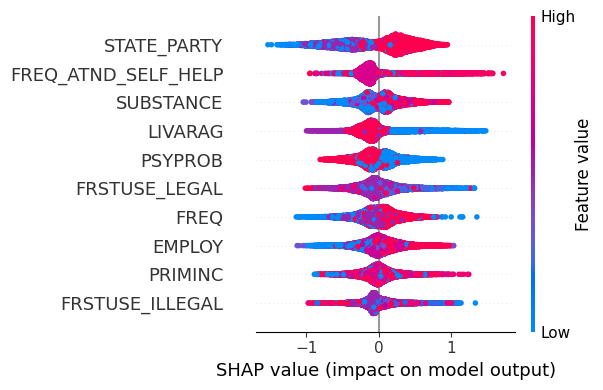

In [24]:
# Plot the SHAP summary plot with beeswarm plot type
shap.summary_plot(shap_values, train_sample, plot_type='dot', plot_size=(6, 4), max_display=10)
